In [1]:
import jax
import jax.numpy as jnp
jax.config.update("jax_enable_x64", True)
jax.config.update('jax_platform_name', 'cpu')

import obe_jax as obj

import matplotlib.pyplot as plt
%matplotlib inline

# Fitting experimental Ramsey data

Assume we have a qubit with unknown frequency $\omega$, unknown $T_2$ time, where single-shot
measurement noise that is gaussian with an unknown standard deviation $\sigma$. 

Experimentally, we apply a $\pi/2$ pulse, wait some duration $\tau$, and apply another $\pi/2$ pulse before measuring in the standard $z$ basis. 

$$|0> ---\bigg[\frac{\pi}{2}\bigg]---\bigg[\text{Idle for }\tau\bigg]---\bigg[\frac{\pi}{2}\bigg] --- [\text{Measure Z basis}] == > \text{0 or 1}$$

Assume we have an estimate to the probability of $0$ after repeating many measurements. In this case the probability should observe the following function of an exponential decay of some oscillating sinusoid:

$$P(\tau) = \exp^{-\frac{\tau}{T_2}}\cos(\frac{\omega}{2}\tau)^2+\frac{1-\exp^{-\frac{\tau}{T_2}}}{2}$$


Also, let's assume that there is Gaussian noise with mean $P(\tau)$ and standard deviation $\sigma$.

Our task is to identify what values of $\tau$ to select so that we can infer, $\omega$, $T_2$, and $\sigma$ from the data.

### First we will define the true parameters that we are attempting to infer


In [2]:
ω = 1.15
T2 = 75.3
σ = 0.02
true_params = jnp.asarray([ω,T2,σ])

### Next we define the likelihood of observing an output $P(\tau)$ given an input $\tau$ and a set of model parameters

In [3]:
@jax.jit
def p_mean(tau,w,T2):
    return jnp.exp(-tau/T2)*jnp.square((jnp.cos(w*tau/2)))+(1-jnp.exp(-tau/T2))/2

p_means = jax.jit(jax.vmap(p_mean,in_axes=(0,None,None))) # Vectorizing the mean function for future plotting convenience

@jax.jit
def likelihood_function(oneinput_vector,oneoutput_vector,oneparameter_vector):
    tau = oneinput_vector[0]
    w,T2,sigma = oneparameter_vector
    yout = oneoutput_vector[0]
    
    mu = p_mean(tau,w,T2)
    p = jnp.exp(-0.5*((mu-yout)/sigma)**2)/(jnp.sqrt(jnp.pi*2)*sigma) # Gaussian noise function
    return p

### Next we define our initial guess regarding possible values of $\omega$, $T_2$, and $\sigma$

### I.e., our "prior" knowledge

In [140]:
key = jax.random.PRNGKey(1234)
key, subkey = jax.random.split(key)
N_particles = 1000
mins = jnp.array([1., 50, 0.00])
maxs = jnp.array([3.5, 200, 0.1])
prior_particles = obj.priors.uniform_prior_particles(subkey,mins,maxs,N_particles)
prior_weights = jnp.full((N_particles,),1/N_particles)

### And define the potential outputs we may observe

In [141]:
N_outcomes = 100
expected_outcomes = jnp.linspace(0,1,N_outcomes).reshape((1,N_outcomes))

### Now we define our Bayseian model

In [142]:
key,subkey = jax.random.split(key)
pdf = obj.AbstractBayesianModel(subkey,prior_particles, prior_weights, expected_outcomes,
                                likelihood_function=likelihood_function, 
                                tuning_parameters = {'resample_threshold':0.5,'auto_resample':True})

In [143]:
pdf.mean()

Array([2.29283114e+00, 1.23476343e+02, 4.99491668e-02], dtype=float64)

## Next we wish to perform adaptive experiments

In order to enable us to "choose" an informative experiment we must consider what experiments we can choose from. 

Thus we must specify some way of creating a set of potential inputs and then choosing the best input from that set. 

We can do this up-front or on-the-fly. We will choose the former as it tends to be more computationally efficient.

In [144]:
N_potential_inputs = 1000 # We will consider 1000 potential inputs

In [145]:
#### TRY DIFFERENT SAMPLINGS OF INPUT POINTS TO SEE INTERESTING EFFECTS:
### Uniform random initial points
key,subkey = jax.random.split(key)
inputs = jax.random.uniform(subkey,minval=0.001,maxval=200., shape=(N_potential_inputs,)).reshape((1,N_potential_inputs))

### Sequential initial points
# inputs = jnp.linspace(0.001,200.0,N_potential_inputs).reshape((1,N_potential_inputs))

### Exponentially random initial points
# key,subkey = jax.random.split(key)
# inputs = jax.random.exponential(subkey, shape=(N_potential_inputs,)).reshape((1,N_potential_inputs))*50

In [146]:
outputs = pdf.sample_outputs(inputs,true_params)

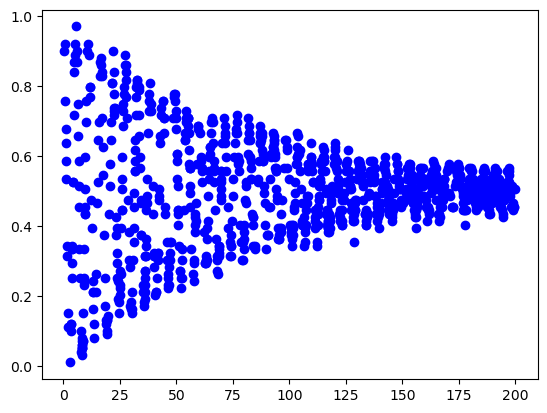

In [147]:
fig, ax = plt.subplots(1,1)
ax.plot(inputs[0,:],outputs[0,:],'bo')
plt.show()

### Now we will infer the systems parameters by selecting the best input to choose at each learning iteration

In [148]:
N_runs = 50
k = 10
recorded_inputs = []
recorded_outputs = []
means = []
stds = []
for i in range(N_runs):
    ## First we examine the expected utility of all the possible inputs:
    ## Caluclating utilites is **expensive** because it requires estimating all possible input-output combinations for each
    ## possible set of model parameters. In our case: N_inputs x N_expected_outputs x N_particles
    ## We can instead *approximate* the utility by using a smaller set of possible particles to calculate utility.
    ## This doesn't degrade the quality of our inference but instead means we will sometimes not choose the absolute
    ## best possible input and we may need some more measurements to compensate. 
    utils = pdf.expected_utilities_k_particles(inputs,k=k) 
    ## Next we choose the input which maximizes each utility:
    single_input = inputs[:,jnp.argmax(utils)]
    recorded_inputs.append(single_input)
    ## Next we will "run" the experiment to get a single output:
    ## In reality this is where you would send off your input to the experimental
    ## setup and wait to receive a result. We will simulate this by sampling from the true model. 
    single_output = pdf.sample_output(single_input,true_params)
    recorded_outputs.append(single_output)
    ## Next we update our posterior
    pdf.bayesian_update(single_input,single_output)
    means.append(pdf.mean())
    stds.append(jnp.sqrt(jnp.diag(pdf.covariance())))

In [149]:
pdf.mean()

Array([1.15059515e+00, 7.69424520e+01, 1.80936886e-02], dtype=float64)

In [150]:
pdf.covariance()

Array([[ 8.44200858e-07, -5.74039865e-04,  3.30582069e-07],
       [-5.74039865e-04,  7.13567525e+00, -1.40656524e-04],
       [ 3.30582069e-07, -1.40656524e-04,  4.75215412e-06]],      dtype=float64)

In [151]:
true_params

Array([1.15e+00, 7.53e+01, 2.00e-02], dtype=float64)

# Mean squared error after learning

In [152]:
mean_array = jnp.stack(means,axis=0)
std_array = jnp.stack(stds,axis=1)

In [153]:
std_array.shape

(3, 50)

In [154]:
rmse = jnp.sqrt((true_params-mean_array)**2/N_particles)

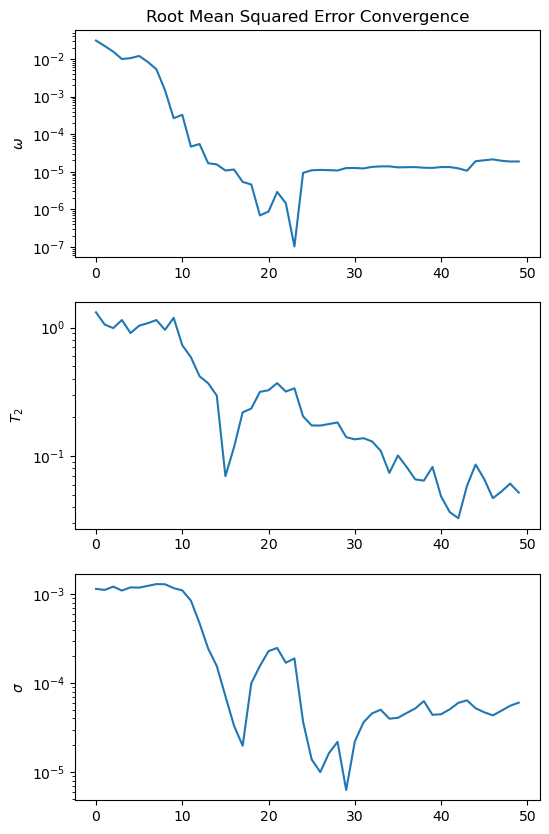

In [155]:
n_figs = 3
fig, axs = plt.subplots(n_figs,1,figsize=(6,10))
axs[0].set_title("Root Mean Squared Error Convergence")
ylabels = [r"$\omega$",r"$T_2$",r"$\sigma$"]
for i in range(n_figs):
    ax = axs[i]
    ax.plot(range(N_runs),rmse[:,i])
    ax.set_yscale('log')
    ax.set_ylabel(ylabels[i])

    
plt.show()

## Visualize the posterior distribution

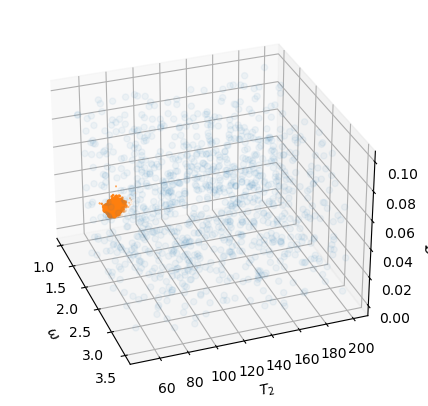

In [156]:
fig, ax = plt.subplots(1,1,subplot_kw={"projection": "3d"},figsize=(5,5))
ax.scatter(prior_particles[0,:], prior_particles[1,:], prior_particles[2,:],alpha=0.05)
ax.scatter(pdf.particles[0,:], pdf.particles[1,:], pdf.particles[2,:],s=pdf.weights*1e4)


ax.set(xlabel=r"$\omega$",
       ylabel=r"$T_2$",
       zlabel=r"$\sigma$")

ax.view_init(azim=-20, elev=30)

plt.show()

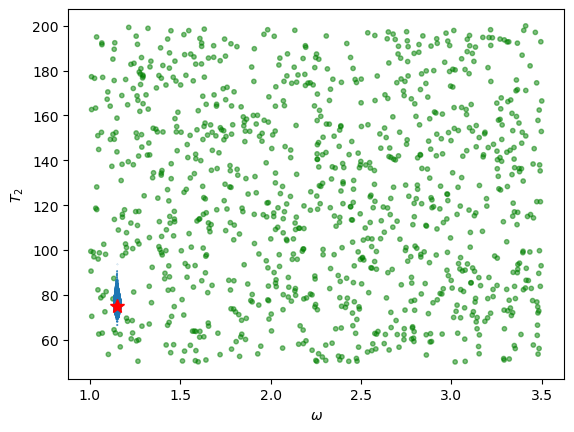

In [157]:
fig, ax = plt.subplots(1,1)
ax.scatter(prior_particles[0,:],prior_particles[1,:],s=prior_weights*1e4,color='green',alpha=0.5)
ax.scatter(pdf.particles[0,:],pdf.particles[1,:],s=pdf.weights*1e4)
ax.plot(true_params[0],true_params[1],"r*",ms=10)
ax.set_xlabel(r"$\omega$")
ax.set_ylabel(r"$T_2$")
plt.show()

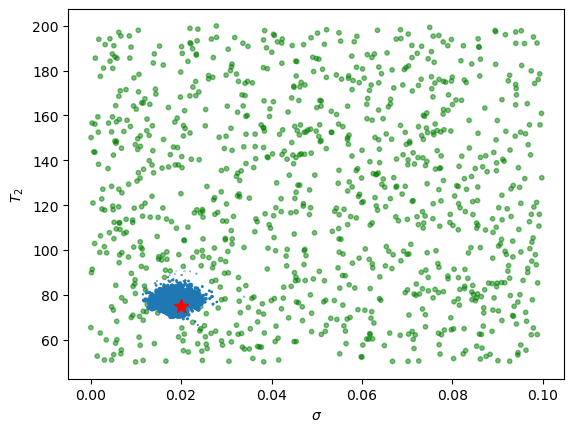

In [158]:
fig, ax = plt.subplots(1,1)
ax.scatter(prior_particles[2,:],prior_particles[1,:],s=prior_weights*1e4,color='green',alpha=0.5)
ax.scatter(pdf.particles[2,:],pdf.particles[1,:],s=pdf.weights*1e4)
ax.plot(true_params[2],true_params[1],"r*",ms=10)
ax.set_xlabel(r"$\sigma$")
ax.set_ylabel(r"$T_2$")
plt.show()

## Visualize the possible particles without noise and identify which experiments were chosen

In [159]:
actual_inputs = jnp.stack(recorded_inputs,axis=1)
actual_outputs = jnp.stack(recorded_outputs,axis=1)

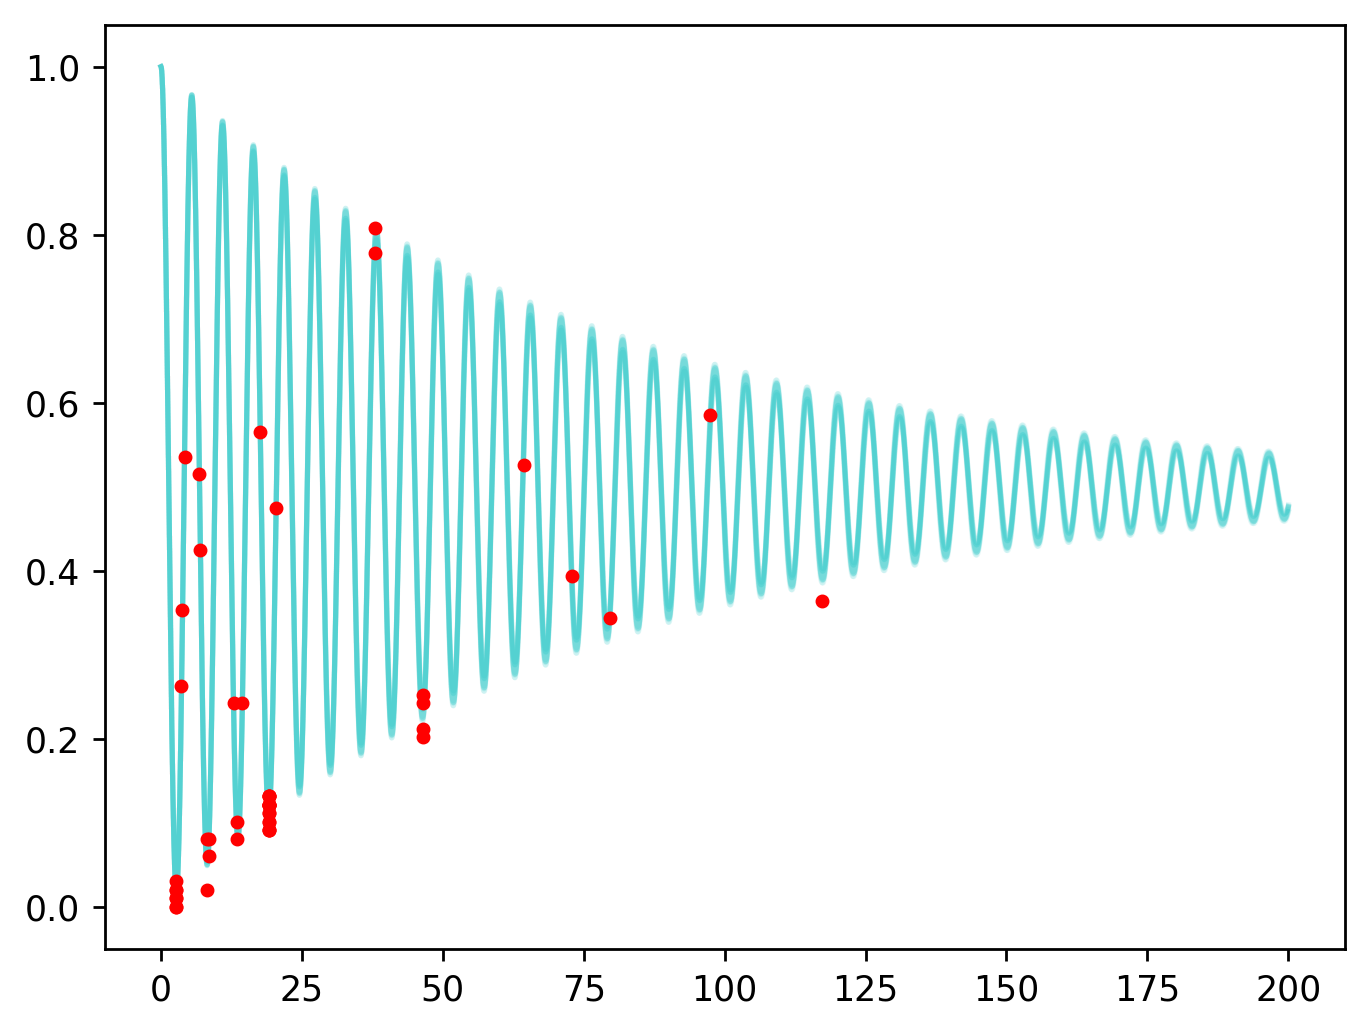

In [160]:
fig, ax = plt.subplots(1,1,dpi=250)
n_plots = 10
ts = jnp.linspace(0,200,100000)
for i in range(n_plots):
    part = pdf.randdraw()
    w,T2,sigma = part
    outs = p_means(ts,w,T2)
    ax.plot(ts,outs[:,0],'-',c='c',alpha=0.1)
    
ax.plot(actual_inputs,actual_outputs,'r.')
# ax.set_xlim(0,100)
plt.show()